In [1]:
import inv_mcmc2ad_red as inv_mcmc2
import numpy as np
from data import Data
from yang import Yang
from mogi import Mogi
from penny import Penny
from okada import Okada
import corner
import matplotlib.pyplot as plt
import pymc

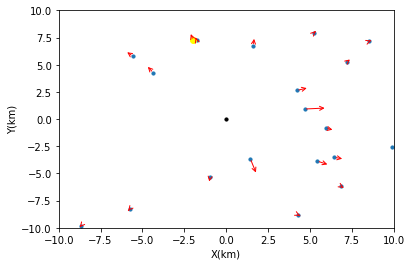

In [2]:
#Number of stations
n=20

#Reference station index
refidx=0

#Generating random x and y positions for the gps stations
ran=np.random.uniform(-10*1e3, 10*1e3, size=(n,2))
x=ran[:,0]
y=ran[:,1]

#Function to generate a noisy yang model
def yang_noisy_model(xcen,ycen,z0,dP,a,b,phi,dip):
    #create data structure
    dat = Data()
    dat.add_locs(x,y)
    yan = Yang(dat)
    ux,uy,uz=yan.forward(xcen=xcen,ycen=ycen,z0=z0,P=dP,a=a,b=b,phi=phi,theta=dip,mu=9.6e9)
    
    ux+=0.5*np.abs(ux)*np.random.uniform(-1,1,len(ux))
    uy+=0.5*np.abs(uy)*np.random.uniform(-1,1,len(uy))
    uz+=0.5*np.abs(uz)*np.random.uniform(-1,1,len(uz))
    
    return ux,uy,uz

#Get noisy displacements on the gps stations due to the Yang model
ux,uy,uz=yang_noisy_model(0,0,3e3,5e8,1e3,5e2,60,30)

#Creating the Data object for the observations
obs=Data()
obs.add_locs(x,y)
obs.add_disp(ux,uy,uz)
obs.set_refidx(refidx)

#Input data for the inversion (deformation reduced with respect to the reference station)
data=obs.get_reduced_obs()

#Plot of the gps vectors
plt.figure()
plt.scatter(x/1e3,y/1e3,s=10)
plt.scatter(x[0]/1e3,y[0]/1e3,c='yellow')
plt.scatter(0,0,s=10,c='black')
scale=3
for i in range(len(x)):
    plt.annotate("", xy=(x[i]/1e3+ux[i]*scale, y[i]/1e3+uy[i]*scale), xytext=(x[i]/1e3, y[i]/1e3),arrowprops=dict(arrowstyle="->",color="red"))
plt.ylim(-10,10)
plt.xlim(-10,10)
plt.ylabel('Y(km)')
plt.xlabel('X(km)')

plt.show()

In [3]:
#Creating the Data object for the postions of the stations on every model
dat = Data()
dat.add_locs(x,y)
dat.set_refidx(refidx)

#Yang model 
yang=Yang(dat)
#Initial parameters [xcen,ycen,depth,pressure,semimajor axis,semimenor axis,strike,dip]
yang.set_x0(np.array([2000,2000,1e3,8.5e8,1e3,5e2,20,20]))
#Bounds for parameters [xcen,ycen,depth,pressure,semimajor axis,semimenor axis,strike,dip]
yang.set_bounds(low_bounds  = [-10000, -10000, 0, 1e8,     100,     100,  10, 0], 
                high_bounds = [ 10000,  10000, 40000,  1e9, 20000, 20000, 70, 360])

#Mogi model
mogi = Mogi(dat)
#Initial parameters [xcen,ycen,depth,volume change]
mogi.set_x0(np.array([0, 0, 20000, 0]))
#Bounds for parameters [xcen,ycen,depth,volume change]
mogi.set_bounds(low_bounds = [-10000, -10000, 200, -1e9], high_bounds = [10000, 10000, 40000, 1e9])

#Penny shaped crack model
penny = Penny(dat)
#Initial parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_x0(np.array([0, 0, 500, 0.01, 1000]))
#Bounds for parameters [xcen,ycen,depth,pressure(shear),radius]
penny.set_bounds(low_bounds = [-10000, -10000, 0, -10, 0], high_bounds = [10000, 10000, 40000, 100, 10000])

#Okada model
okada = Okada(dat)
#Defining type two options (open,slip)
okada.set_type('open')
#Initial parameters [xcen,ycen,depth,length,width,opening,strike,dip]
okada.set_x0(np.array([0, 0, 1e3, 1e3, 1e3,10.0,1.0,1.0]))
#Bounds for parameters [xcen,ycen,depth,length,width,opening,strike,dip]
okada.set_bounds(low_bounds = [-10000, -10000, 0, 0, 0, 0, 0, 0], high_bounds = [10000, 10000, 10000, 10000, 10000,50.0,360.0,90.0])

#Inversion using in this case Mogi model
trace,MDL=inv_mcmc2.inversion(mogi,data)

 [-----------------100%-----------------] 110000 of 110000 complete in 36.2 sec

Plotting ycen
Plotting depth
Plotting xcen
Plotting dV
Plotting sigma


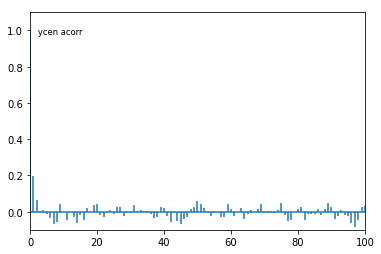

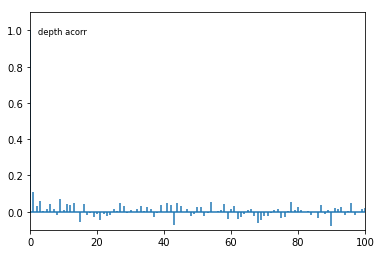

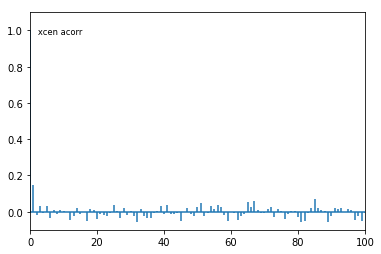

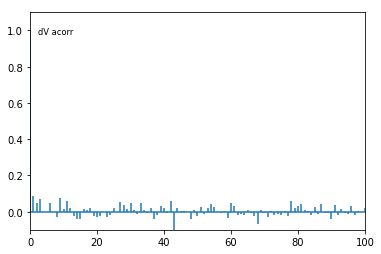

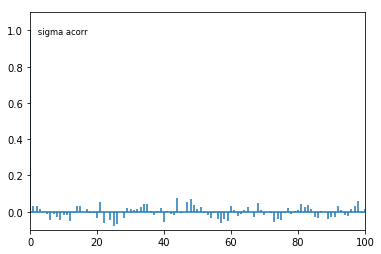

In [4]:
#Autocorrelation plots
pymc.Matplot.autocorrelation(MDL)

1000
1000
1000
1000


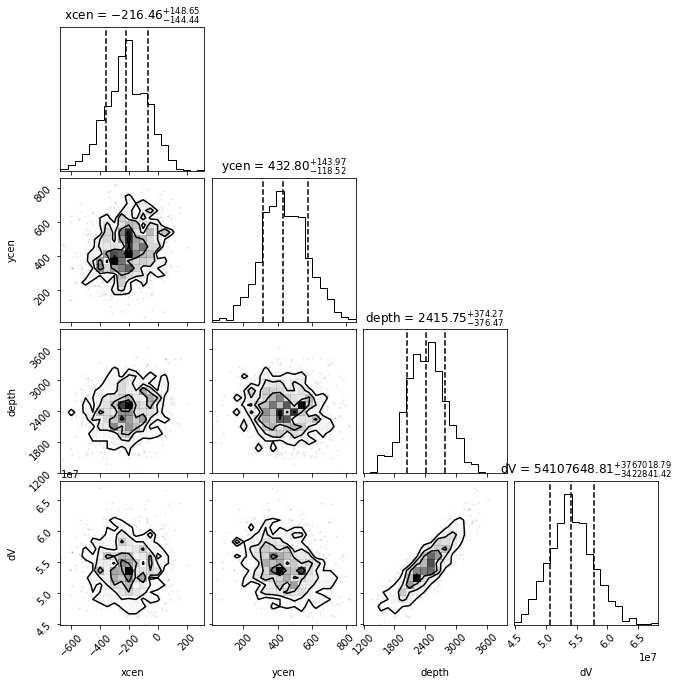

In [5]:
data=[]
labels=[]
parnames=mogi.get_parnames()
orders=mogi.get_orders()
for i,tr in enumerate(trace):
    print(len(tr[:]))
    data.append(tr[:]*orders[i])
    labels.append(parnames[i])
data=np.vstack(data)
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})